In this tp you will find an example of translation from english to french using pytorch. You can easily modify the code to perform the translation from french to english.

In [ ]:
import logging
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
import unicodedata
import string
from tqdm import tqdm
from pathlib import Path
from typing import List
from itertools import chain
import matplotlib.pyplot as plt

import time
import re
from torch.utils.tensorboard import SummaryWriter




logging.basicConfig(level=logging.INFO)


def normalize(s):
    return re.sub(' +',' ', "".join(c if c in string.ascii_letters else " "
         for c in unicodedata.normalize('NFD', s.lower().strip())
         if  c in string.ascii_letters+" "+string.punctuation)).strip()



class Vocabulary:
    """Permet de gérer un vocabulaire.

    En test, il est possible qu'un mot ne soit pas dans le
    vocabulaire : dans ce cas le token "__OOV__" est utilisé.
    Attention : il faut tenir compte de cela lors de l'apprentissage !

    Utilisation:

    - en train, utiliser v.get("blah", adding=True) pour que le mot soit ajouté
      automatiquement
    - en test, utiliser v["blah"] pour récupérer l'ID du mot (ou l'ID de OOV)
    """
    PAD = 0
    EOS = 1
    SOS = 2
    OOVID = 3

    def __init__(self, oov: bool):
        self.oov = oov
        self.id2word = ["PAD", "EOS", "SOS"]
        self.word2id = {"PAD": Vocabulary.PAD, "EOS": Vocabulary.EOS, "SOS": Vocabulary.SOS}
        if oov:
            self.word2id["__OOV__"] = Vocabulary.OOVID
            self.id2word.append("__OOV__")

    def __getitem__(self, word: str):
        if self.oov:
            return self.word2id.get(word, Vocabulary.OOVID)
        return self.word2id[word]

    def get(self, word: str, adding=True):
        try:
            return self.word2id[word]
        except KeyError:
            if adding:
                wordid = len(self.id2word)
                self.word2id[word] = wordid
                self.id2word.append(word)
                return wordid
            if self.oov:
                return Vocabulary.OOVID
            raise

    def __len__(self):
        return len(self.id2word)

    def getword(self, idx: int):
        if idx < len(self):
            return self.id2word[idx]
        return None

    def getwords(self, idx: List[int]):
        return [self.getword(i) for i in idx]



class TradDataset():
    def __init__(self,data,vocOrig,vocDest,adding=True,max_len=10):
        self.sentences =[]
        for s in tqdm(data.split("\n")):
            if len(s)<1:continue
            orig,dest=map(normalize,s.split("\t")[:2])
            if len(orig)>max_len: continue
            self.sentences.append((torch.tensor([vocOrig.get(o) for o in orig.split(" ")]+[Vocabulary.EOS]),torch.tensor([vocDest.get(o) for o in dest.split(" ")]+[Vocabulary.EOS])))
    def __len__(self):return len(self.sentences)
    def __getitem__(self,i): return self.sentences[i]
    def getSizes(self): return len(vocEng), len(vocFra)



def collate(batch):
    orig,dest = zip(*batch)
    o_len = torch.tensor([len(o) for o in orig])
    d_len = torch.tensor([len(d) for d in dest])
    return pad_sequence(orig),o_len,pad_sequence(dest),d_len



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Download and open the data
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1u9wP8BY6GjR94AVqlA3Qq9KR1y_qi27y',
                                    dest_path='./en-fra.txt')
with open('en-fra.txt') as f:
    lines = f.readlines()

lines = [lines[x] for x in torch.randperm(len(lines))]
idxTrain = int(0.8*len(lines))

vocEng = Vocabulary(True)
vocFra = Vocabulary(True)
MAX_LEN=100
BATCH_SIZE=100

#input_size = len(vocEng)
#output_size = len(vocFra)
num_layers=1
embedding_size = 200
hidden_size = 164

datatrain = TradDataset("".join(lines[:idxTrain]),vocEng,vocFra,max_len=MAX_LEN)
datatest = TradDataset("".join(lines[idxTrain:]),vocEng,vocFra,max_len=MAX_LEN)

train_loader = DataLoader(datatrain, collate_fn=collate, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datatest, collate_fn=collate, batch_size=BATCH_SIZE, shuffle=True)

input_size, output_size = datatrain.getSizes()


100%|██████████| 3504/3504 [00:00<00:00, 20278.55it/s]


In [ ]:
class encoder(nn.Module):
  
  def __init__(self,input_size, hidden_size, num_layers, embedding_size):
    super(encoder, self).__init__()
    
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    
    self.embed = nn.Embedding(input_size, embedding_size, padding_idx = Vocabulary.PAD)
    self.gru = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=False)
    
        
  def forward(self, x, batch_sizes):
    
    x = self.embed(x)
    x = torch.nn.utils.rnn.pack_padded_sequence(x.data,batch_sizes,enforce_sorted=False)
    _, hn = self.gru(x)
    
    return hn



class decoder(nn.Module):
  
  def __init__(self,input_size, hidden_size, num_layers, embedding_size, output_size):
    super(decoder, self).__init__()
    
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    
    self.emb = nn.Embedding(output_size, embedding_size, padding_idx = Vocabulary.PAD)
    self.gru = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=False)
    self.linear = nn.Linear(hidden_size, output_size)
    
        
  def forward(self, y, batch_sizes, h0, mode='contraint'):
    
    if mode == 'contraint':
        starts = torch.tensor([[Vocabulary.SOS] * y.shape[1]],dtype=torch.int)
        starts = starts.to(device)
        y = torch.cat((starts,y[:-1])) 
            
        
        y = self.emb(y)
        y = torch.nn.utils.rnn.pack_padded_sequence(y.data,batch_sizes,enforce_sorted=False)
        out, hn = self.gru(y, h0)
        output, batch_sizes = torch.nn.utils.rnn.pad_packed_sequence(out)
        output = self.linear(output)
        return output
    else:
        res = [self.generate(h0[0][i].unsqueeze(0).unsqueeze(0),len_seq = y.shape[0]) for i in range(h0.shape[1])]
        if y.shape[0] - res[0].shape[0] != 0: # to be sure that same size as before
            to_add = torch.zeros((y.shape[0] - res[0].shape[0],res[0].shape[1]))
            to_add[:,Vocabulary.PAD] = 1
            to_add = to_add.to(device)
            res[0] = torch.cat([res[0],to_add]) 
        res = pad_sequence(res,batch_first=True,padding_value=Vocabulary.PAD)

        res = res.transpose(0,1)
        return res

  def generate(self,hidden,len_seq=None,return_hidden = False, start = None):
    '''
        Take a hidden state and return a sentence of size len_seq or less
    '''
    i = 0
    cur_state = torch.tensor(Vocabulary.SOS) if start is None else torch.tensor(start)
    cur_state = cur_state.to(device)
    outputs = []
    
    while (len_seq is None or len_seq != i):
        cur_state = self.emb(cur_state)
        cur_state = cur_state.unsqueeze(0).unsqueeze(0)
        
        _, hn = self.gru(cur_state, hidden)
        hidden = hn
        output = self.linear(hn)[0]
        
        output_normalized = torch.nn.functional.softmax(output[0],dim = 0)
        cur_state = torch.argmax(output_normalized)
        outputs += [output[0]]
        if cur_state.item() == Vocabulary.EOS:
            break

        i += 1
    if return_hidden:
        return torch.stack(outputs), hidden
    return torch.stack(outputs)


In [ ]:
nepochs = 100

enc = encoder(input_size, hidden_size, num_layers, embedding_size).to(device)
dec = decoder(input_size, hidden_size, num_layers, embedding_size, output_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = Vocabulary.PAD).to(device)
optimizer = torch.optim.Adam(chain(enc.parameters(), dec.parameters()),lr=0.003)

In [ ]:
#l=[]
enc.train()
dec.train()
for epoch in range(nepochs):
    L=0
    for i, (x, x_size, y, y_size)  in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        
        hn = enc(x, x_size)
        mode = 'contraint' if torch.rand(1).item() else 'non contraint'
        out = dec(y, y_size, hn, mode)
        loss = criterion(out.reshape(-1, out.shape[2]), y.flatten())

        with torch.no_grad():
            loss.backward()
            optimizer.step()
            L += loss.item()

    print("Epoch:", epoch, "loss:", L/i)
    l.append(L/i)

Epoch: 0 loss: 96.78742174421038
Epoch: 1 loss: 95.51721354893276
Epoch: 2 loss: 95.10952535356795
Epoch: 3 loss: 95.94549140930175
Epoch: 4 loss: 97.46272065298898
Epoch: 5 loss: 97.31585093906948
Epoch: 6 loss: 98.82089914594378
Epoch: 7 loss: 100.35586825779507
Epoch: 8 loss: 98.4081273487636
Epoch: 9 loss: 98.75928895132883
Epoch: 10 loss: 97.34538083757673
Epoch: 11 loss: 96.68699460710798
Epoch: 12 loss: 96.95753059387206
Epoch: 13 loss: 98.87419662475585
Epoch: 14 loss: 101.78673760550363
Epoch: 15 loss: 101.01584968566894
Epoch: 16 loss: 101.68714076450892
Epoch: 17 loss: 102.09367877415248
Epoch: 18 loss: 100.94966615949359
Epoch: 19 loss: 98.84937433515276
Epoch: 20 loss: 100.3335568019322
Epoch: 21 loss: 102.4523615700858
Epoch: 22 loss: 102.346456854684
Epoch: 23 loss: 101.15298658098493
Epoch: 24 loss: 100.93251680646624
Epoch: 25 loss: 99.68282094682966
Epoch: 26 loss: 99.3845333644322
Epoch: 27 loss: 96.89693080357142
Epoch: 28 loss: 97.77776685442244
Epoch: 29 loss: 100

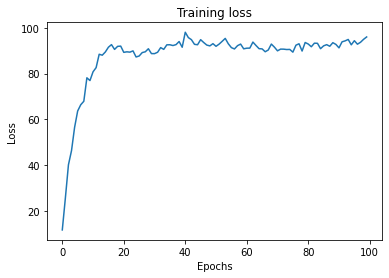

In [ ]:
plt.plot(l)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

Ps: I really don't know why my loss is increasing but the results seems acceptable for only 50 epochs. If someone can fix it or get better results, please, let me know!

In [ ]:
Ltest = 0
enc.eval()
dec.eval()
for i, (x, x_size, y, y_size)  in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    
    hn = enc(x, x_size)
    mode = 'non contraint'
    out = dec(y, y_size, hn, mode)
    loss = criterion(out.reshape(-1, out.shape[2]), y.flatten())
    Ltest+=loss.item()

print("Different between test and train losses:", Ltest/i - l[-1])

Different between test and train losses: 397.8997566768101


In [ ]:
def generate_sentence(sentence, s_size, enc, dec, string2code, id2lettre, eos, maxlen=200, determinist=True, nucleus=False, alpha=0.95):
    """  Fonction de génération (l'embedding et le decodeur être des fonctions du rnn). Initialise le réseau avec start (ou à 0 si start est vide) et génère une séquence de longueur maximale 200 ou qui s'arrête quand eos est généré.
        * rnn : le réseau
        * emb : la couche d'embedding
        * decoder : le décodeur
        * eos : ID du token end of sequence
        * start : début de la phrase
        * maxlen : longueur maximale
    """
    #  TODO:  Implémentez la génération à partir du RNN, et d'une fonction decoder qui renvoie les logits (logarithme de probabilité à une constante près, i.e. ce qui vient avant le softmax) des différentes sorties possibles

    mode='non contraint'
    translation = []

    for _ in range(1):
      hn = enc(sentence, s_size)
      out = dec(sentence, s_size, hn, mode)

      out = out.reshape((-1,out.shape[2]))

      p_x = nn.functional.softmax(out,dim=1)
      
      word_idx = torch.argmax(p_x, dim=1)
      
      for word in word_idx:
        if word.item() == 1:
          break
        translation.append(id2lettre[word.item()])
          
    return translation

In [ ]:
x, x_size, y, y_size = next(iter(test_loader))

for i in range(10):
  sentence = x[:,i].to(device)
  s_size = x_size[i].reshape((-1))

  eng = ' '.join(vocEng.id2word[id.item()] for id in sentence if id.item() > 1)
  print("English sentence:", eng)

  fr = generate_sentence(sentence.reshape((-1,1)), s_size, enc, dec, vocFra.word2id, vocFra.id2word, Vocabulary.EOS, maxlen=200, determinist=True)
  print("French sentence:", ' '.join(fr))
  print('')

English sentence: the switch is on
French sentence: bouge toi le bureau

English sentence: who called you
French sentence: qui vous l as a trahi

English sentence: i often read
French sentence: j ai un ouvrage de retraite

English sentence: you re fearless
French sentence: tu es malpoli ouverte

English sentence: this is false
French sentence: c est un mot

English sentence: did you get it
French sentence: as tu fait un genie

English sentence: i knew too much
French sentence: j ai un chien

English sentence: this isn t safe
French sentence: n as fait ses bagages

English sentence: we re biased
French sentence: nous nous nous nous nous nous

English sentence: she shot him
French sentence: le monde ment

